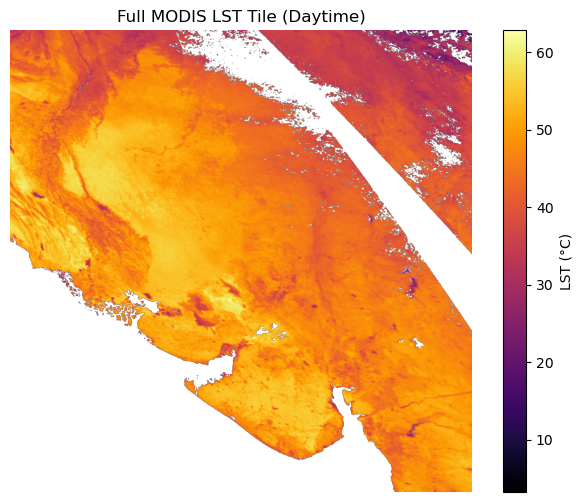

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

file = r"C:\Users\swarn\OneDrive\Documents\archive\MYD11A1_061-20251028_151309\MYD11A1.A2024122.h24v06.061.2024124120616.hdf"
subdataset = f'HDF4_EOS:EOS_GRID:"{file}":MODIS_Grid_Daily_1km_LST:LST_Day_1km'

with rasterio.open(subdataset) as src:
    data = src.read(1)

data = data.astype(float)
data[data == 0] = np.nan
data = data * 0.02 - 273.15

plt.figure(figsize=(8,6))
plt.imshow(data, cmap='inferno')
plt.colorbar(label="LST (°C)")
plt.title("Full MODIS LST Tile (Daytime)")
plt.axis('off')
plt.show()


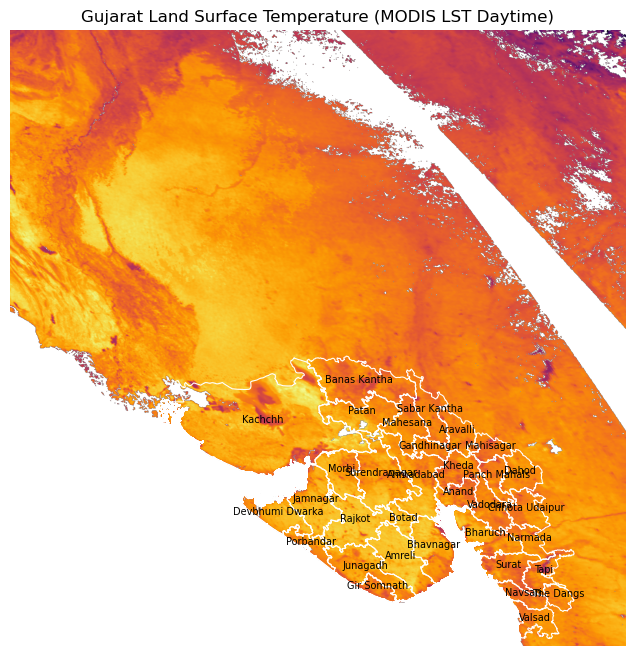

In [68]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from shapely.geometry import box

# 🔹 MODIS LST HDF file path
file = r"C:\Users\swarn\OneDrive\Documents\archive\MYD11A1_061-20251028_151309\MYD11A1.A2024122.h24v06.061.2024124120616.hdf"
subdataset = f'HDF4_EOS:EOS_GRID:"{file}":MODIS_Grid_Daily_1km_LST:LST_Day_1km'

# 🔹 Load LST data
with rasterio.open(subdataset) as src:
    data = src.read(1)
    transform = src.transform
    crs = src.crs

# 🔹 Convert to Celsius and clean
data = data.astype(float)
data[data == 0] = np.nan
data = data * 0.02 - 273.15

# 🔹 Load India district shapefile (Level 2)
shapefile_path = r"C:\Users\swarn\Downloads\gadm41_IND_shp\gadm41_IND_2.shp"
gdf = gpd.read_file(shapefile_path)

# 🔹 Filter Gujarat
gujarat = gdf[gdf['NAME_1'] == 'Gujarat']

# 🔹 Reproject to match raster CRS
gujarat = gujarat.to_crs(crs)

# 🔹 Create plot
fig, ax = plt.subplots(figsize=(10, 8))
show(data, transform=transform, cmap='inferno', ax=ax)
gujarat.boundary.plot(ax=ax, color='white', linewidth=0.8)

# 🔹 Add district names
for idx, row in gujarat.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(x, y, row['NAME_2'], fontsize=7, color='black', ha='center')

# 🔹 Final touches
ax.set_title("Gujarat Land Surface Temperature (MODIS LST Daytime)")
ax.axis('off')
plt.show()


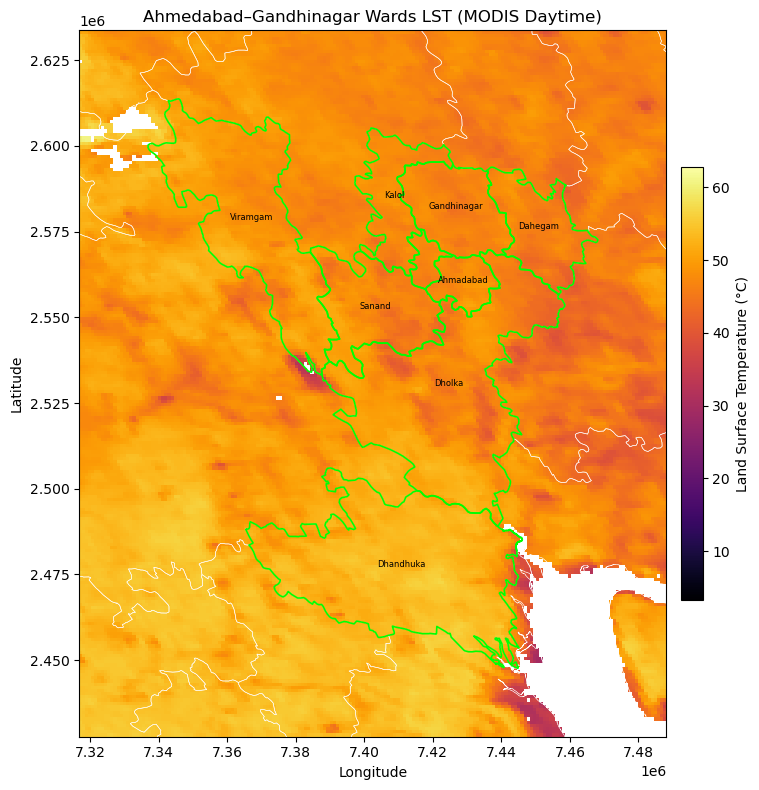

In [91]:
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# === File paths ===
file = r"C:\Users\swarn\OneDrive\Documents\archive\MYD11A1_061-20251028_151309\MYD11A1.A2024122.h24v06.061.2024124120616.hdf"
districts_path = r"C:\Users\swarn\Downloads\gadm41_IND_shp\gadm41_IND_2.shp"
wards_path = r"C:\Users\swarn\Downloads\gadm41_IND_shp\gadm41_IND_3.shp"

# === Load MODIS LST subdataset ===
subdataset = f'HDF4_EOS:EOS_GRID:"{file}":MODIS_Grid_Daily_1km_LST:LST_Day_1km'
with rasterio.open(subdataset) as src:
    lst = src.read(1).astype(float)
    lst[lst == 0] = np.nan
    lst = lst * 0.02 - 273.15
    transform = src.transform
    crs = src.crs
    bounds = src.bounds

# === Load shapefiles ===
gdf_districts = gpd.read_file(districts_path)
gdf_wards = gpd.read_file(wards_path)

# === Reproject shapefiles to raster CRS ===
gdf_districts = gdf_districts.to_crs(crs)
gdf_wards = gdf_wards.to_crs(crs)

# === Filter for Ahmedabad & Gandhinagar wards ===
focus = gdf_wards[gdf_wards["NAME_2"].isin(["Ahmadabad", "Gandhinagar"])].copy()

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 8))

# Plot full raster
img = ax.imshow(lst, cmap="inferno", extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))

# Plot all Gujarat districts for context
gdf_districts.boundary.plot(ax=ax, edgecolor="white", linewidth=0.4)

# Highlight Ahmedabad & Gandhinagar wards
focus.boundary.plot(ax=ax, edgecolor="lime", linewidth=1.2)

# Label ward names
for _, row in focus.iterrows():
    if not row.geometry.is_empty:
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        ax.text(x, y, row["NAME_3"], fontsize=6, color="black", ha="center")

# === Zoom into Ahmedabad–Gandhinagar region ===
minx, miny, maxx, maxy = focus.total_bounds
ax.set_xlim(minx - 20000, maxx + 20000)
ax.set_ylim(miny - 20000, maxy + 20000)

# === Add temperature scale ===
cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Land Surface Temperature (°C)")

plt.title("Ahmedabad–Gandhinagar Wards LST (MODIS Daytime)", fontsize=12)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


In [ ]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import ndimage

# === Folder paths ===
input_folder = r"C:\Users\swarn\OneDrive\Documents\archive\MYD11A1_061-20251028_151309"
output_folder = r"C:\Users\swarn\Downloads\LST_FILES"
districts_path = r"C:\Users\swarn\Downloads\gadm41_IND_shp\gadm41_IND_2.shp"
wards_path = r"C:\Users\swarn\Downloads\gadm41_IND_shp\gadm41_IND_3.shp"

# === Make sure output folder exists ===
os.makedirs(output_folder, exist_ok=True)

# === Load shapefiles once ===
gdf_districts = gpd.read_file(districts_path)
gdf_wards = gpd.read_file(wards_path)

# === Filter Ahmedabad & Gandhinagar wards ===
focus = gdf_wards[gdf_wards["NAME_2"].isin(["Ahmadabad", "Gandhinagar"])].copy()

# === Loop over all HDF files ===
for file in os.listdir(input_folder):
    if not file.lower().endswith(".hdf"):
        continue

    full_path = os.path.join(input_folder, file)
    print(f"Processing: {file}")

    try:
        # --- Load subdataset ---
        subdataset = f'HDF4_EOS:EOS_GRID:"{full_path}":MODIS_Grid_Daily_1km_LST:LST_Day_1km'
        with rasterio.open(subdataset) as src:
            lst = src.read(1).astype(float)

            # === Clean invalid pixels ===
            lst[(lst == 0) | (lst < 7500)] = np.nan
            lst = lst * 0.02 - 273.15
            lst[(lst < -20) | (lst > 70)] = np.nan

            # === Fill small gaps ===
            mask = np.isnan(lst)
            lst_filled = ndimage.generic_filter(lst, np.nanmean, size=3)
            lst[mask] = lst_filled[mask]

            transform = src.transform
            crs = src.crs
            bounds = src.bounds

        # === Reproject shapefiles to match raster CRS (once per run) ===
        gdf_districts = gdf_districts.to_crs(crs)
        gdf_wards = gdf_wards.to_crs(crs)
        focus = gdf_wards[gdf_wards["NAME_2"].isin(["Ahmadabad", "Gandhinagar"])].copy()

        # === Plot ===
        fig, ax = plt.subplots(figsize=(8, 8))
        img = ax.imshow(lst, cmap="inferno", extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))

        gdf_districts.boundary.plot(ax=ax, edgecolor="white", linewidth=0.4)
        focus.boundary.plot(ax=ax, edgecolor="lime", linewidth=1.2)

        for _, row in focus.iterrows():
            if not row.geometry.is_empty:
                x, y = row.geometry.centroid.x, row.geometry.centroid.y
                ax.text(x, y, row["NAME_3"], fontsize=6, color="black", ha="center")

        minx, miny, maxx, maxy = focus.total_bounds
        ax.set_xlim(minx - 20000, maxx + 20000)
        ax.set_ylim(miny - 20000, maxy + 20000)

        cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.02)
        cbar.set_label("Land Surface Temperature (°C)")

        plt.title(f"Ahmedabad–Gandhinagar LST (MODIS Daytime)\n{file}", fontsize=11)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()

        # === Save output ===
        output_path = os.path.join(output_folder, f"{os.path.splitext(file)[0]}.png")
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f" Saved: {output_path}")

    except Exception as e:
        print(f" Error processing {file}: {e}")

print("\n All files processed and maps saved successfully!")


Processing: MYD11A1.A2024122.h24v06.061.2024124120616.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024122.h24v06.061.2024124120616.png
Processing: MYD11A1.A2024123.h24v06.061.2024124214009.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024123.h24v06.061.2024124214009.png
Processing: MYD11A1.A2024124.h24v06.061.2024125203111.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024124.h24v06.061.2024125203111.png
Processing: MYD11A1.A2024125.h24v06.061.2024126182606.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024125.h24v06.061.2024126182606.png
Processing: MYD11A1.A2024126.h24v06.061.2024127190133.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024126.h24v06.061.2024127190133.png
Processing: MYD11A1.A2024127.h24v06.061.2024131032500.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024127.h24v06.061.2024131032500.png
Processing: MYD11A1.A2024128.h24v06.061.2024131054941.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024128.h24v06.061.2024131054941.png
Processing: MYD11A1.A2024129.h24v06.061.2024131063447.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024129.h24v06.061.2024131063447.png
Processing: MYD11A1.A2024130.h24v06.061.2024131204051.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024130.h24v06.061.2024131204051.png
Processing: MYD11A1.A2024131.h24v06.061.2024132185039.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024131.h24v06.061.2024132185039.png
Processing: MYD11A1.A2024132.h24v06.061.2024133175937.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024132.h24v06.061.2024133175937.png
Processing: MYD11A1.A2024133.h24v06.061.2024135012206.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024133.h24v06.061.2024135012206.png
Processing: MYD11A1.A2024134.h24v06.061.2024136075748.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024134.h24v06.061.2024136075748.png
Processing: MYD11A1.A2024135.h24v06.061.2024137005428.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024135.h24v06.061.2024137005428.png
Processing: MYD11A1.A2024136.h24v06.061.2024137175701.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024136.h24v06.061.2024137175701.png
Processing: MYD11A1.A2024137.h24v06.061.2024139031814.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024137.h24v06.061.2024139031814.png
Processing: MYD11A1.A2024138.h24v06.061.2024139202836.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024138.h24v06.061.2024139202836.png
Processing: MYD11A1.A2024139.h24v06.061.2024142123505.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024139.h24v06.061.2024142123505.png
Processing: MYD11A1.A2024140.h24v06.061.2024143140004.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024140.h24v06.061.2024143140004.png
Processing: MYD11A1.A2024141.h24v06.061.2024143151807.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024141.h24v06.061.2024143151807.png
Processing: MYD11A1.A2024142.h24v06.061.2024144043509.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024142.h24v06.061.2024144043509.png
Processing: MYD11A1.A2024143.h24v06.061.2024144220608.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024143.h24v06.061.2024144220608.png
Processing: MYD11A1.A2024144.h24v06.061.2024145181716.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024144.h24v06.061.2024145181716.png
Processing: MYD11A1.A2024145.h24v06.061.2024146175807.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024145.h24v06.061.2024146175807.png
Processing: MYD11A1.A2024146.h24v06.061.2024148115107.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024146.h24v06.061.2024148115107.png
Processing: MYD11A1.A2024147.h24v06.061.2024148183300.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024147.h24v06.061.2024148183300.png
Processing: MYD11A1.A2024148.h24v06.061.2024152024442.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024148.h24v06.061.2024152024442.png
Processing: MYD11A1.A2024149.h24v06.061.2024152025939.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024149.h24v06.061.2024152025939.png
Processing: MYD11A1.A2024150.h24v06.061.2024156151035.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024150.h24v06.061.2024156151035.png
Processing: MYD11A1.A2024151.h24v06.061.2024156221407.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024151.h24v06.061.2024156221407.png
Processing: MYD11A1.A2024152.h24v06.061.2024157072147.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024152.h24v06.061.2024157072147.png
Processing: MYD11A1.A2024153.h24v06.061.2024157142000.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024153.h24v06.061.2024157142000.png
Processing: MYD11A1.A2024154.h24v06.061.2024157211714.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024154.h24v06.061.2024157211714.png
Processing: MYD11A1.A2024155.h24v06.061.2024157233201.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024155.h24v06.061.2024157233201.png
Processing: MYD11A1.A2024156.h24v06.061.2024159004843.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024156.h24v06.061.2024159004843.png
Processing: MYD11A1.A2024157.h24v06.061.2024160204842.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024157.h24v06.061.2024160204842.png
Processing: MYD11A1.A2024158.h24v06.061.2024161072952.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024158.h24v06.061.2024161072952.png
Processing: MYD11A1.A2024159.h24v06.061.2024162043120.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024159.h24v06.061.2024162043120.png
Processing: MYD11A1.A2024160.h24v06.061.2024162191846.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024160.h24v06.061.2024162191846.png
Processing: MYD11A1.A2024161.h24v06.061.2024162223412.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024161.h24v06.061.2024162223412.png
Processing: MYD11A1.A2024162.h24v06.061.2024163203817.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024162.h24v06.061.2024163203817.png
Processing: MYD11A1.A2024163.h24v06.061.2024165202246.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024163.h24v06.061.2024165202246.png
Processing: MYD11A1.A2024164.h24v06.061.2024165202701.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024164.h24v06.061.2024165202701.png
Processing: MYD11A1.A2024165.h24v06.061.2024166235031.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024165.h24v06.061.2024166235031.png
Processing: MYD11A1.A2024166.h24v06.061.2024167181743.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024166.h24v06.061.2024167181743.png
Processing: MYD11A1.A2024167.h24v06.061.2024168180852.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024167.h24v06.061.2024168180852.png
Processing: MYD11A1.A2024168.h24v06.061.2024169172351.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024168.h24v06.061.2024169172351.png
Processing: MYD11A1.A2024169.h24v06.061.2024170183343.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024169.h24v06.061.2024170183343.png
Processing: MYD11A1.A2024170.h24v06.061.2024175192011.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024170.h24v06.061.2024175192011.png
Processing: MYD11A1.A2024171.h24v06.061.2024175195032.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024171.h24v06.061.2024175195032.png
Processing: MYD11A1.A2024172.h24v06.061.2024175202209.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024172.h24v06.061.2024175202209.png
Processing: MYD11A1.A2024173.h24v06.061.2024175202544.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024173.h24v06.061.2024175202544.png
Processing: MYD11A1.A2024174.h24v06.061.2024175222202.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024174.h24v06.061.2024175222202.png
Processing: MYD11A1.A2024175.h24v06.061.2024177232445.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024175.h24v06.061.2024177232445.png
Processing: MYD11A1.A2024176.h24v06.061.2024180065450.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024176.h24v06.061.2024180065450.png
Processing: MYD11A1.A2024177.h24v06.061.2024181110842.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024177.h24v06.061.2024181110842.png
Processing: MYD11A1.A2024178.h24v06.061.2024181125702.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024178.h24v06.061.2024181125702.png
Processing: MYD11A1.A2024179.h24v06.061.2024181175112.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024179.h24v06.061.2024181175112.png
Processing: MYD11A1.A2024180.h24v06.061.2024181223037.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024180.h24v06.061.2024181223037.png
Processing: MYD11A1.A2024181.h24v06.061.2024182183214.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024181.h24v06.061.2024182183214.png
Processing: MYD11A1.A2024182.h24v06.061.2024183231820.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024182.h24v06.061.2024183231820.png
Processing: MYD11A1.A2024183.h24v06.061.2024184172921.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024183.h24v06.061.2024184172921.png
Processing: MYD11A1.A2024184.h24v06.061.2024185193519.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024184.h24v06.061.2024185193519.png
Processing: MYD11A1.A2024185.h24v06.061.2024186171731.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024185.h24v06.061.2024186171731.png
Processing: MYD11A1.A2024186.h24v06.061.2024187175953.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024186.h24v06.061.2024187175953.png
Processing: MYD11A1.A2024187.h24v06.061.2024188172011.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024187.h24v06.061.2024188172011.png
Processing: MYD11A1.A2024188.h24v06.061.2024190075915.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024188.h24v06.061.2024190075915.png
Processing: MYD11A1.A2024189.h24v06.061.2024190181731.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024189.h24v06.061.2024190181731.png
Processing: MYD11A1.A2024190.h24v06.061.2024195001206.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024190.h24v06.061.2024195001206.png
Processing: MYD11A1.A2024191.h24v06.061.2024195013805.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024191.h24v06.061.2024195013805.png
Processing: MYD11A1.A2024192.h24v06.061.2024195053031.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024192.h24v06.061.2024195053031.png
Processing: MYD11A1.A2024193.h24v06.061.2024195055219.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024193.h24v06.061.2024195055219.png
Processing: MYD11A1.A2024194.h24v06.061.2024197190521.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024194.h24v06.061.2024197190521.png
Processing: MYD11A1.A2024195.h24v06.061.2024197200006.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024195.h24v06.061.2024197200006.png
Processing: MYD11A1.A2024196.h24v06.061.2024197223008.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024196.h24v06.061.2024197223008.png
Processing: MYD11A1.A2024197.h24v06.061.2024198175211.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024197.h24v06.061.2024198175211.png
Processing: MYD11A1.A2024198.h24v06.061.2024199214038.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024198.h24v06.061.2024199214038.png
Processing: MYD11A1.A2024199.h24v06.061.2024200213500.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024199.h24v06.061.2024200213500.png
Processing: MYD11A1.A2024200.h24v06.061.2024201190232.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024200.h24v06.061.2024201190232.png
Processing: MYD11A1.A2024201.h24v06.061.2024202172550.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024201.h24v06.061.2024202172550.png
Processing: MYD11A1.A2024202.h24v06.061.2024203172744.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024202.h24v06.061.2024203172744.png
Processing: MYD11A1.A2024203.h24v06.061.2024204175609.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024203.h24v06.061.2024204175609.png
Processing: MYD11A1.A2024204.h24v06.061.2024205174119.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024204.h24v06.061.2024205174119.png
Processing: MYD11A1.A2024205.h24v06.061.2024207001558.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024205.h24v06.061.2024207001558.png
Processing: MYD11A1.A2024206.h24v06.061.2024209082058.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024206.h24v06.061.2024209082058.png
Processing: MYD11A1.A2024207.h24v06.061.2024209090003.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024207.h24v06.061.2024209090003.png
Processing: MYD11A1.A2024208.h24v06.061.2024209205524.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024208.h24v06.061.2024209205524.png
Processing: MYD11A1.A2024209.h24v06.061.2024210172657.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024209.h24v06.061.2024210172657.png
Processing: MYD11A1.A2024210.h24v06.061.2024211172231.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024210.h24v06.061.2024211172231.png
Processing: MYD11A1.A2024211.h24v06.061.2024212174532.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024211.h24v06.061.2024212174532.png
Processing: MYD11A1.A2024212.h24v06.061.2024213201232.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024212.h24v06.061.2024213201232.png
Processing: MYD11A1.A2024213.h24v06.061.2024222022342.hdf


c:\Users\swarn\anaconda3\envs\heat_island\lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


✅ Saved: C:\Users\swarn\Downloads\LST_FILES\MYD11A1.A2024213.h24v06.061.2024222022342.png

🎯 All files processed and maps saved successfully!
